In [43]:
import string
from pickle import load
from pickle import dump
from numpy import array
from numpy.random import shuffle
from numpy import argmax

# import Keras functions
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import plot_model
from tensorflow.keras import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

from attention import Attention

# import BLEU calculator from NLTK
from nltk.translate.bleu_score import corpus_bleu

# Preprocess data

In [44]:
# Get data
with open('pol.txt', 'r', encoding='utf-8') as f:
    pol_dataset = f.read()
    
# lower
pol_dataset = pol_dataset.lower()

# Split samples
pol_lines = pol_dataset.strip().split('\n')
pol_data = [i.split('\t')[:2] for i in pol_lines]

# Remove punctuation
def remove_punct(sentence):
    for punct in string.punctuation:
        sentence = sentence.replace(punct, '')
    return sentence
    
for i in pol_data:
    i[0] = remove_punct(i[0])
    i[1] = remove_punct(i[1])

In [45]:
# Shuffle data
shuffle(pol_data)
pol_splitpoint = len(pol_data) // 10
pol_train_data = pol_data[:-pol_splitpoint]
pol_test_data = pol_data[-pol_splitpoint:]

# Save data
dump(pol_data, open('pol_data.txt', 'wb'))
dump(pol_train_data, open('pol_train_data.txt', 'wb'))
dump(pol_test_data, open('pol_test_data.txt', 'wb'))

# Train eng2pol

In [46]:
# Load data
pol_data = load(open('pol_data.txt', 'rb'))
pol_train_data = load(open('pol_train_data.txt', 'rb'))
pol_test_data = load(open('pol_test_data.txt', 'rb'))

pol_data = array(pol_data)
pol_train_data = array(pol_train_data)
pol_test_data = array(pol_test_data)

In [47]:
# fit a tokenizer
eng_tokenizer = Tokenizer()
eng_tokenizer.fit_on_texts(pol_data[:, 0])

pol_tokenizer = Tokenizer()
pol_tokenizer.fit_on_texts(pol_data[:, 1])

eng_vocab_size = len(eng_tokenizer.word_index) + 1
pol_vocab_size = len(pol_tokenizer.word_index) + 1

In [48]:
print(max(len(i.split()) for i in pol_data[:, 0]))
print(max(len(i.split()) for i in pol_data[:, 1]))

47
38


In [49]:
# set sentence length
eng_length = 10
pol_length = 10

In [50]:
# encode and pad sequences
trainX = eng_tokenizer.texts_to_sequences(pol_train_data[:, 0])
trainX = pad_sequences(trainX, maxlen= eng_length, padding='post')

testX = eng_tokenizer.texts_to_sequences(pol_test_data[:, 0])
testX = pad_sequences(testX, maxlen= eng_length, padding='post')

trainY = pol_tokenizer.texts_to_sequences(pol_train_data[:, 1])
trainY = pad_sequences(trainY, maxlen= pol_length, padding='post')

testY = pol_tokenizer.texts_to_sequences(pol_test_data[:, 1])
testY = pad_sequences(testY, maxlen= pol_length, padding='post')

In [51]:
# define the encoder-decoder model
n_units = 64
embedding_size = 200

# encoder
eng_input = Input(shape=(eng_length,), dtype='float32')
embedding = Embedding(eng_vocab_size, embedding_size, input_length=eng_length)(eng_input)
encoder_gru = Bidirectional(GRU(n_units*2, return_sequences=True, dropout=0.2))(embedding)
encoder_att = Attention()(encoder_gru)
# decoder
repeat = RepeatVector(pol_length)(encoder_att)
decoder_gru = Bidirectional(GRU(n_units*2, return_sequences=True, dropout=0.2))(repeat)
pol_output = TimeDistributed(Dense(pol_vocab_size, activation='softmax'))(decoder_gru)
model = Model(eng_input, pol_output)

# create a german to english translation model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

# summarise the model
print(model.summary())
plot_model(model, to_file='model.png', show_shapes=True)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 10)]         0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 10, 200)      1702600     input_2[0][0]                    
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 10, 256)      253440      embedding_4[0][0]                
__________________________________________________________________________________________________
last_hidden_state (Lambda)      (None, 256)          0           bidirectional[0][0]              
____________________________________________________________________________________________

In [9]:
# define the encoder-decoder model
n_units = 64
embedding_size = 200

# encoder
eng_input = Input(shape=(eng_length, ), dtype='float32')
embedding = Embedding(eng_vocab_size, embedding_size, input_length=eng_length)(eng_input)
encoder_gru = GRU(n_units, dropout=0.2)(embedding)
# encoder_att = Attention()(encoder_gru)
# decoder
repeat = RepeatVector(pol_length)(encoder_gru)
decoder_gru = GRU(n_units, return_sequences=True, dropout=0.2)(repeat)
pol_output = TimeDistributed(Dense(pol_vocab_size, activation='softmax'))(decoder_gru)
model = Model(eng_input, pol_output)

# create a german to english translation model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

# summarise the model
print(model.summary())
plot_model(model, to_file='model.png', show_shapes=True)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 10, 200)           1702600   
_________________________________________________________________
gru (GRU)                    (None, 64)                51072     
_________________________________________________________________
repeat_vector (RepeatVector) (None, 10, 64)            0         
_________________________________________________________________
gru_1 (GRU)                  (None, 10, 64)            24960     
_________________________________________________________________
time_distributed (TimeDistri (None, 10, 21560)         1401400   
Total params: 3,180,032
Trainable params: 3,180,032
Non-trainable params: 0
___________________________________________________

In [30]:
# because training takes time, we checkpoint the model during training
# this saves the partially trained model any time that the validation loss is reduced
filename = 'model.h5'
checkpoint = ModelCheckpoint(filename, monitor = 'val_loss', verbose = 1, save_best_only = True, mode = 'min')
history = model.fit(trainX, trainY, epochs = 5, batch_size = 512, validation_data = (testX, testY), callbacks = [checkpoint], verbose = 2)

Epoch 1/5
73/73 - 169s - loss: 5.4814 - val_loss: 4.4007

Epoch 00001: val_loss improved from inf to 4.40069, saving model to model.h5
Epoch 2/5
73/73 - 165s - loss: 4.2841 - val_loss: 4.2935

Epoch 00002: val_loss improved from 4.40069 to 4.29346, saving model to model.h5
Epoch 3/5
73/73 - 165s - loss: 4.1392 - val_loss: 4.1844

Epoch 00003: val_loss improved from 4.29346 to 4.18443, saving model to model.h5
Epoch 4/5
73/73 - 166s - loss: 4.0568 - val_loss: 4.1468

Epoch 00004: val_loss improved from 4.18443 to 4.14678, saving model to model.h5
Epoch 5/5
73/73 - 165s - loss: 4.0191 - val_loss: 4.1249

Epoch 00005: val_loss improved from 4.14678 to 4.12490, saving model to model.h5


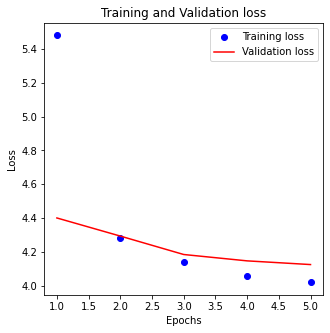

In [31]:
# get the history dictionary 
hist=history.history
epochs=range(1,len(hist['loss'])+1)

import matplotlib.pyplot as plt
%matplotlib inline

# plot loss curves
plt.figure(figsize=(5,5))
plt.plot(epochs,hist['loss'],'bo',label="Training loss")
plt.plot(epochs,hist['val_loss'],'r-',label="Validation loss")
plt.title("Training and Validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Predict

In [42]:
# load model
model = load_model('model.h5')

# evaluate the performance of the model
actual = []
predicted = []
for i, sample in enumerate(testX):
    sample = sample.reshape((1, sample.shape[0]))
    prediction = model.predict(sample, verbose=0)[0]
    integers = [argmax(vector) for vector in prediction]
    target = []
    for j in integers:
        for w, index in pol_tokenizer.word_index.items():
            word = w if index == j else None
        if word is None:
            break
        target.append(word)
    translation = ' '.join(target)
    
    if i < 10:
        print('src=[%s], target=[%s], predicted=[%s]' % (pol_test_data[i][0], pol_test_data[i][1], translation))
        
    actual.append([pol_test_data[i][1].split()])
    predicted.append(translation.split())
    
    print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
    print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
    print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
    print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

src=[myanmar is ruled by a military dictatorship], target=[w myanmarze rządzi dyktatura wojskowa], predicted=[]
BLEU-1: 0.000000
BLEU-2: 0.000000
BLEU-3: 0.000000
BLEU-4: 0.000000
src=[tom took the day off], target=[tom wziął dzień wolnego], predicted=[]
BLEU-1: 0.000000
BLEU-2: 0.000000
BLEU-3: 0.000000
BLEU-4: 0.000000
src=[i promise you ill look after you], target=[przyrzekam że będę się tobą opiekował], predicted=[]
BLEU-1: 0.000000
BLEU-2: 0.000000
BLEU-3: 0.000000
BLEU-4: 0.000000
src=[they have time to spend with their families or to enjoy their hobbies], target=[mają czas żeby spędzać go z rodzinami albo uprawiać swoje hobby], predicted=[]
BLEU-1: 0.000000
BLEU-2: 0.000000
BLEU-3: 0.000000
BLEU-4: 0.000000
src=[where can i park my car], target=[gdzie mogę zaparkować samochód], predicted=[]
BLEU-1: 0.000000
BLEU-2: 0.000000
BLEU-3: 0.000000
BLEU-4: 0.000000
src=[he should arrive at the airport by 9 am], target=[powinien dotrzeć na lotnisko przed 900], predicted=[]
BLEU-1: 0.0000

BLEU-1: 0.000000
BLEU-2: 0.000000
BLEU-3: 0.000000
BLEU-4: 0.000000
BLEU-1: 0.000000
BLEU-2: 0.000000
BLEU-3: 0.000000
BLEU-4: 0.000000
BLEU-1: 0.000000
BLEU-2: 0.000000
BLEU-3: 0.000000
BLEU-4: 0.000000
BLEU-1: 0.000000
BLEU-2: 0.000000
BLEU-3: 0.000000
BLEU-4: 0.000000
BLEU-1: 0.000000
BLEU-2: 0.000000
BLEU-3: 0.000000
BLEU-4: 0.000000
BLEU-1: 0.000000
BLEU-2: 0.000000
BLEU-3: 0.000000
BLEU-4: 0.000000
BLEU-1: 0.000000
BLEU-2: 0.000000
BLEU-3: 0.000000
BLEU-4: 0.000000
BLEU-1: 0.000000
BLEU-2: 0.000000
BLEU-3: 0.000000
BLEU-4: 0.000000
BLEU-1: 0.000000
BLEU-2: 0.000000
BLEU-3: 0.000000
BLEU-4: 0.000000
BLEU-1: 0.000000
BLEU-2: 0.000000
BLEU-3: 0.000000
BLEU-4: 0.000000
BLEU-1: 0.000000
BLEU-2: 0.000000
BLEU-3: 0.000000
BLEU-4: 0.000000
BLEU-1: 0.000000
BLEU-2: 0.000000
BLEU-3: 0.000000
BLEU-4: 0.000000
BLEU-1: 0.000000
BLEU-2: 0.000000
BLEU-3: 0.000000
BLEU-4: 0.000000
BLEU-1: 0.000000
BLEU-2: 0.000000
BLEU-3: 0.000000
BLEU-4: 0.000000
BLEU-1: 0.000000
BLEU-2: 0.000000
BLEU-3: 0.0000

KeyboardInterrupt: 